## Respuestas pregunta 3

* ¿Qué performance tiene? 

    * El modelo tiene una buena performance en cuanto a detector de reggaetones y una excelente performance como predictor de tracks que no lo son tanto en términos de precisión como de alcance. Es débil en cuanto alcance para los tracks que son reggaeton, es decir su capacidad de identificar adecuadamente la totalidad o una alta proporción de los tracks que son reggaeton dentro de una muestra. 
    El trade-off que se hizo en este caso fue obtener mayor precisión a costa una menor sensibilidad de la identificación de tracks de reggaeton bajo el supuesto de que estamos en un contexto de recomendador de tracks músicales y es preferible que la recomendación sea buena cuando se haga aunque algunas canciones no estén dentro del alcance del modelo inicialmente.


* ¿Qué métricas usas para evaluar esa performance? 

    * Las métricas utilizadas y los resultados obtenidos con el umbral de probabilidad de ser un track de reggaeton en 81% son: 

        * Con este umbral, los resultados finales quedan de la siguiente forma:

            * Accuracy: 97% (sube un punto porcentual)
            * Roc auc score: 0.95 (queda igual)
            * Sensitivity: 48% (baja 4 puntos porcentuales)
            * Specificity: 99% (sube 1 punto porcentual)
            * Precisión de la clase positiva: 75% (sube 13 puntos porcentuales)
            * Precisión de la clase negativa: 98% 

** Los comentarios en paréntesis son la comparación con respecto a un umbral de probabilidad predicha de ser reggaeton de 0.5**


* ¿Por qué elegiste ese algoritmo en particular? 

    * Elegí el Gradient Boosting porque:
        
        * Porque este algoritmo normalmente funciona bien para problemas de clasificación con pocos datos y se puede controlar bien el sobre ajuste (ver referencias). 
        La razón es que construye varios árboles cuyos resultados luego va promediando y se espera que cada árbol pueda sobreajustar un conjunto de datos pero sub-ajustar otro, por lo que luego de promediar no debería existir ni sobre ni sub ajuste. Adicionalmente, tiene varios parámetros que hemos modificado para disminuir la probabilidad de sobre-ajuste, como el pedir un 3% a un 5% de los datos para generar un split o un nodo, que utilice una muestra aleatoria del 80% de los datos para construir cada árbol y el la tasa de aprendizaje.
        
        * De los 5 algoritmos que probamos, este era el que entregaban mayor precisión para predecir tracks de reggaeton y un buen balance en el resto de las métricas (Accuracy, roc-auc,etc)


** Referencias: ** 

*<https://stats.stackexchange.com/questions/257328/why-is-boosting-less-likely-to-overfit>*

*<https://www.quora.com/What-are-the-advantages-disadvantages-of-using-Gradient-Boosting-over-Random-Forests>*

*<https://www.quora.com/What-the-pros-and-cons-of-using-a-combination-of-boosting-+-decision-trees-vs-some-other-approach-in-a-classification-problem>*

* ¿Cómo podrías mejorar la performance ?

    * En una 3era iteración probaría las siguientes modificaciones:

        * Una forma de mejorar la performance sería probando otras técnicas de balance de clases que puedan funcionar mejor que la creación de clases sintéticas mediante vecinos cercanos (que es lo que hace el Smote)
        
        * Crear una variable a partir de la detección de pertenencia a un cluster, para luego usarlo como feature para predecir con otro de árbol o regresión
     
        * Usar otros algoritmos que normalmente tienen buena performance para problemas de clasificación binaria como *XGboost* y/o algún algoritmo que use redes neuronales       
        
        * Aplicar *anomaly detection*, es decir detectar la presencia de reggaeton como una anomalia, lo cual es muy utilizado en problemas de clasificación cuando hay una clase minoritaria muy pequeña, como es este caso.       
        
        * Implementar un módulo de entrenamiento, para lo cual deberíamos bajar el umbral de probabilidad a 50%, de tal forma que la precisión de la detección de reggaetones sea solo de 52% y en la medida que nos vayamos equivocando se van agregando esos casos etiquetados adecuadamente para re-entrenar el modelo

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from time import time
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import seaborn as sns
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from scipy.stats import chi2
from sklearn.preprocessing import MinMaxScaler,binarize
from sklearn.feature_selection import SelectKBest,mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.metrics import roc_curve,classification_report,confusion_matrix,make_scorer
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')

#### Plot functions

* Funciones personalizadas creadas para visualizar los datos

** References: ** 
*<https://stackoverflow.com/questions/9497524/displaying-3-histograms-on-1-axis-in-a-legible-way-matplotlib>*
*<>*

In [2]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

## EDA

* En esta etapa realizaremos la exploración y comprensión de la estructura/distribución de los datos. Para ello realizaremos las siguientes tareas:

    * **Caracterización general del dataset:** En esta etapa revisaremos las características del dataset generales del 
      dataset en cuanto a estructura (número de registros y variables, significado y tipos de variables, cantidad de 
      NA's)      

    * **Análisis univariado:** En donde evaluaremos cada variable por si sola en cuanto a su distribución y 
      características propias (características de los NA's, outliers, valores fuera de rango, etc), así como las 
      diferencias en ellas (si es que existen) cuando pertenencen a canciones de reggaeton y cuando no.
      
    * **Análisis multivariado:** Se evaluarán las relaciones entre las variables y la influencia conjunta con respecto a 
      la variable target (cuando es reggaeton y cuando no)

### Caracterización general del dataset

* Hay 2230 registros de canciones de todo tipo y 70 de reggaeton. Las variables para ambos dataset son similares a excpeción de *time_signature* que solo está presente en las canciones de todo tipo.


* Las variables *key* y *mode* son enteros que representan categorías, mientras que *duration* es una variable que representa el tiempo en milisegundo. El resto de las variables corresponden a distintos score numéricos que representan características de los track como popularidad, qué tan apto es para el baile, qué tan vocal o instrumental es, etc.


* Podemos ver que la cantidad de NA's es 0 para los track de reggaeton y muy baja para los track de otro tipo, en donde ninguna variable tiene más de 8 valores NAs, correspondientes a un 0.36% de los datos. 


* **Dada la baja proporción de NAs y que estos corresponden al dataset que contiene la clase mayoritaria no se harán imputaciones y se trabajará solo con los datos completos.**

In [3]:
df_todotipo=pd.read_csv('data_todotipo.csv',encoding='utf-8',sep=',')
del df_todotipo['Unnamed: 0']
df_todotipo=df_todotipo.dropna(how='any',axis=0).copy()
df_reggaeton=pd.read_csv('data_reggaeton.csv',encoding='utf-8',sep=',')
del df_reggaeton['Unnamed: 0']

#### Union de los datasets

* Para analizar el resto de las variables vamos a trabajar con el dataset ya unido, de tal forma que podamos comparar la variable cuando es reggaeton y cuando no de forma más simple y rápida.


* Para ello definiremos una variable *reggaeton* como 1 cuando sea un track de reggaeton y con valor 0 en cualquier otro caso. Posteriormente, unificaremos los tipos de datos de ambos dataset y finalmente haremos la unión.

In [4]:
del df_todotipo['time_signature']
df_reggaeton['reggaeton']=1
df_todotipo['reggaeton']=0
df_reggaeton['popularity']=df_reggaeton.popularity.astype('float64')
df_reggaeton['duration']=df_reggaeton.duration.astype('float64')
df=pd.concat([df_reggaeton,df_todotipo]).copy()
print(df.shape)
df.head(3)

(2292, 15)


,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,id_new,reggaeton
0,68.0,0.826,0.704,9.0,-7.527,1.0,0.1170,0.1890,0.000048,0.0617,0.741,94.013,205000.0,1,1
1,61.0,0.641,0.693,8.0,-7.327,1.0,0.1630,0.0169,0.000000,0.2190,0.899,214.058,184413.0,2,1
2,67.0,0.771,0.815,1.0,-5.423,0.0,0.0719,0.1610,0.000020,0.1890,0.524,94.016,205520.0,3,1


* Nuestra primera tarea será hacer el encoding de las variables categóricas para que Python las entienda como tal

* La segunda, dejar todas las variables numéricas en una escala similar

** Referencias: **
*<http://pbpython.com/categorical-encoding.html>*

In [5]:
df.loc[:,"key_code"] = df.key.astype('category')
df.loc[:,"mode_code"] = df['mode'].astype('category')
del df['key']
del df['mode']
del df['id_new']
df.loc[:,"reggaeton"] = df.reggaeton.astype('category')
df.loc[:,'loudness_scale']=MinMaxScaler().fit_transform(df[['loudness']])
df.loc[:,'tempo_scale']=MinMaxScaler().fit_transform(df[['tempo']])
del df['loudness']
del df['tempo']
df.dtypes

popularity           float64
danceability         float64
energy               float64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
duration             float64
reggaeton           category
key_code            category
mode_code           category
loudness_scale       float64
tempo_scale          float64
dtype: object

In [6]:
df.isnull().sum()

popularity          0
danceability        0
energy              0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
duration            0
reggaeton           0
key_code            0
mode_code           0
loudness_scale      0
tempo_scale         0
dtype: int64

Información del dataset:
 las clases del target son: Counter({0: 2222, 1: 70})


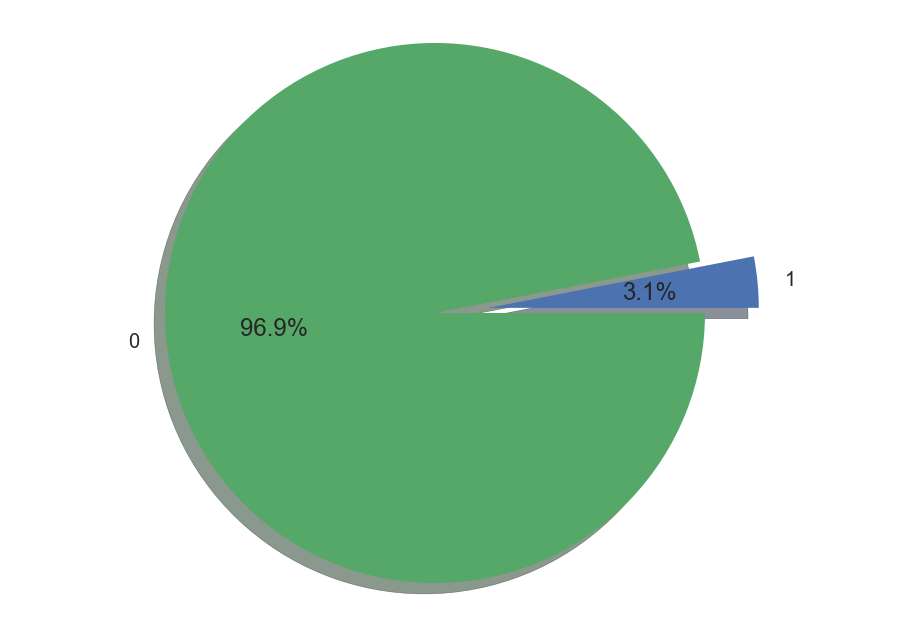

In [7]:
X=df.loc[:, df.columns != 'reggaeton']
y=df.reggaeton.ravel()
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(y)

### Selección de variables

* Basados en el análisis estadístico, en los resultados de la métrica Mutual Information, el orden de importancia por coeficiente de SVClineal y por los resultados de aplicar Recursive feature engineer con los algoritmos Random Forest, Gradient Boosting y Regresión logística se decide eliminar 5 variables que eran candidatas:
    * *duration*
    * *liveness*
    * *loudness*
    * *key_code*
    * *instrumentalness*

In [8]:
del X['key_code']
del X['duration']
del X['popularity']
del X['mode_code']
del X['instrumentalness']
del X['loudness_scale']
del X['liveness']

### Entrenamiento

#### Estructura del dataset

* Para entrenar el modelo vamos a dividir el dataset de forma aleatoria en un 70% para entrenar y un 30% para testear, de tal forma que las proporciones de las clases se mantengan constantes

* Para atacar el problema de balance de clases,usaremos la técnica SMOTE, que genera variables sintéticas hasta generar la misma cantidad de casos de la clase mayoritaría para la que era minoritaria. En este caso, no usaremos RandomUnderSample dado que la clase minoritaria representa apenas un 3% de los datos

* Se tendrá especial cuidado en usar la técnica de balance de clases **solo para los datos de entrenamiento**, ya que los datos de test siempre deben estar sin manipulación de este tipo

Información del dataset:
 las clases del target son: Counter({0: 1565, 1: 39})


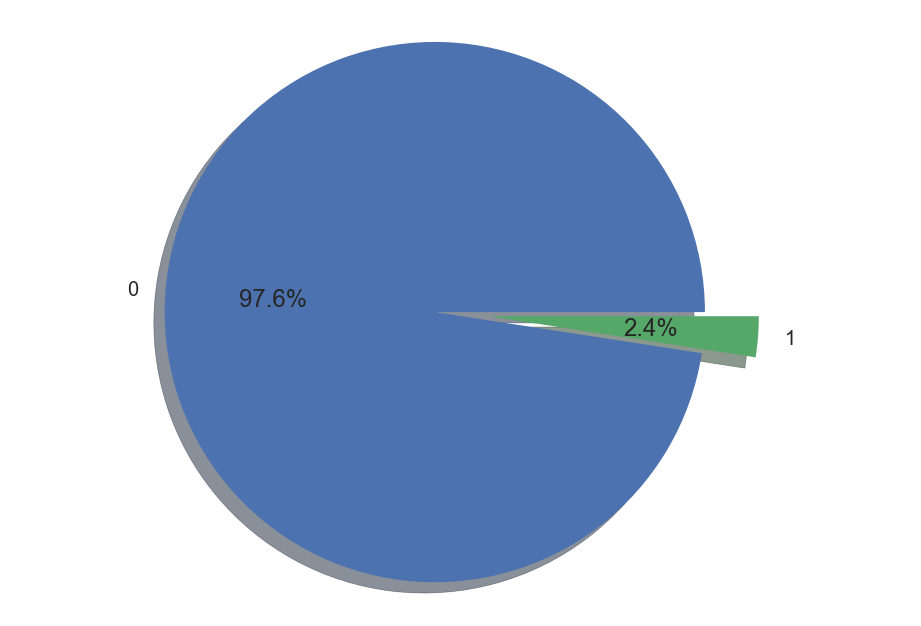

In [9]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.3)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

Información del dataset aplicando el algoritmo Smote:
 y: Counter({0: 1565, 1: 1565})


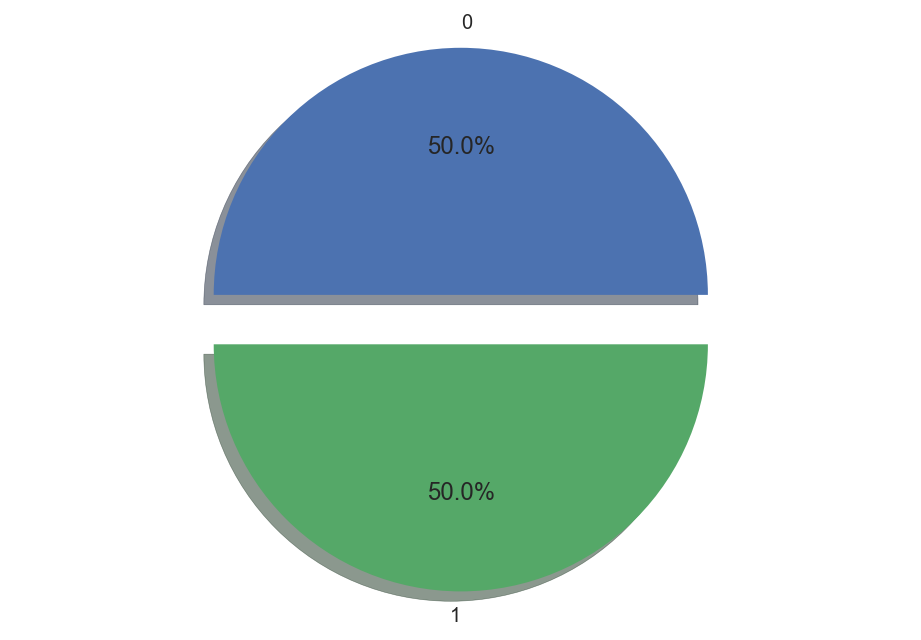

In [10]:
sm = SMOTE(random_state=0,n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print('Información del dataset aplicando el algoritmo Smote:'
      '\n y: {}'.format(Counter(y_train_res)))
plot_pie(y_train_res)

#### Estimación de los mejores parámetros con  GridsearchCV

* Utilizaremos el accuracy como métrica para determinar los mejores parámetros utilizando el algoritmo GridsearchCV

** References: **
*<http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html>*

In [11]:
# Functions to select the best parameters for each model

# This function creates all the classifiers that will be used
def create_classifiers():
    classifier_LR = LogisticRegression(random_state=0,max_iter=300,warm_start=True)
    classifier_RF = RandomForestClassifier(bootstrap=True,n_estimators=300,random_state=0,n_jobs=-1,
                                           warm_start=True)
    classifier_GB = GradientBoostingClassifier(random_state=0,subsample=0.8,n_estimators=300,presort=True,
                                               warm_start=True,learning_rate=0.01)
    algorithms=[classifier_LR,classifier_RF,classifier_GB]
    
    return algorithms

# This function creates the parameters which will be tested for each algorithm
def create_parameters():
    parameters_LR = {'C':[0.01,0.1,0.5,1,5,10]}
    parameters_RF = {'criterion':['gini','entropy'],'max_features':['sqrt','auto','log2'],
                     'min_samples_split':[93,156],'min_samples_leaf':[93,156]}

    parameters_GB = {'max_features':['sqrt','auto','log2'],'min_samples_split':[75,125],
                     'min_samples_leaf':[75,125],'learning_rate':[0.01,0.05]}
    
    parameters=[parameters_LR,parameters_RF,parameters_GB]
    
    return parameters

# This function execute the GridsearchCV with for all the algorithms wich the parameters given and return
# the main metrics for binary classification problems and the best parameters 
def get_best_param(X_train,y_train,classifiers):
    params_metrics={}
    for i in range(0,len(classifiers)):
        classifiers[i].fit(X_train,y_train)
        params_metrics.update({classifiers[i].estimator.__class__.__name__:
                 {
                  'accuracy':classifiers[i].cv_results_.get('mean_test_accuracy')[classifiers[i].best_index_],
                  #'precision':classifiers[i].cv_results_.get('mean_test_precision')[classifiers[i].best_index_],
                  #'F1':classifiers[i].cv_results_.get('mean_test_F1')[classifiers[i].best_index_],
                  #'recall':classifiers[i].cv_results_.get('mean_test_recall')[classifiers[i].best_index_],
                  #'roc-auc':classifiers[i].cv_results_.get('mean_test_roc-auc-score')[classifiers[i].best_index_],
                  'best_params':classifiers[i].best_params_
                 }
                })
        
    return params_metrics

In [12]:
scores={'accuracy': make_scorer(accuracy_score)}
parameters=create_parameters()

In [13]:
algorithms=create_classifiers()
clf=[]
for i in range(0,len(algorithms)):
    clf.append(GridSearchCV(estimator=algorithms[i], param_grid=parameters[i],cv=10,scoring=scores,refit='accuracy')) 
best_parameters_res=get_best_param(X_train=X_train_res,y_train=y_train_res,classifiers=clf);

In [14]:
best_parameters_res

{'GradientBoostingClassifier': {'accuracy': 0.984664536741214,
  'best_params': {'learning_rate': 0.05,
   'max_features': 'auto',
   'min_samples_leaf': 125,
   'min_samples_split': 75}},
 'LogisticRegression': {'accuracy': 0.897444089456869,
  'best_params': {'C': 5}},
 'RandomForestClassifier': {'accuracy': 0.9594249201277956,
  'best_params': {'criterion': 'entropy',
   'max_features': 'sqrt',
   'min_samples_leaf': 93,
   'min_samples_split': 93}}}

### Entrenamiento

* Se utilizaran 3 modelos para entrenar utilizando validación cruzada con k=10 y el dataset de entrenamiento balanceado con el algoritmo Smote

* Se evaluaran todas las métricas de clasificación y se escogerá aquel modelo que obtenga el mejor balance de ellas. Sin embargo, las principales serán el Accuracy y el F1

* Para los algoritmos de Random Forest y Gradient Boosting se restringe la mínima cantiad de datos para que los árboles hagan split, para que se cree un nodo final y la máxima cantidad de features. Todo esto con el objetivo de disminuir el riesgo de sobre-ajuste. Al GB también se le indica que tome muestras del 80% para construir los árboles, de tal forma que el algoritmo no se aprenda los datos *de memoria* en la medida que va haciendo la convergencia

In [15]:
# Functions to restart the classifiers with the the best parameters selected for each model

def restart_classifiers(best_parameters):
    
    classifier_LR = LogisticRegression(
        random_state=0,max_iter=300,warm_start=True,class_weight=None,
        C=best_parameters.get('LogisticRegression').get('best_params').get('C'),
    )
    
    classifier_RF = RandomForestClassifier(
        n_estimators=300,random_state=0,n_jobs=-1,bootstrap=True,warm_start=True,
        criterion=best_parameters.get('RandomForestClassifier').get('best_params').get('criterion'),
        max_features=best_parameters.get('RandomForestClassifier').get('best_params').get('max_features'),
        min_samples_split=best_parameters.get('RandomForestClassifier').get('best_params').get('min_samples_split'),
        min_samples_leaf=best_parameters.get('RandomForestClassifier').get('best_params').get('min_samples_leaf')
      
    )
    
    
    classifier_GB = GradientBoostingClassifier(
        random_state=0,subsample=0.8,n_estimators=300,presort=True,warm_start=True,
        max_features=best_parameters.get('GradientBoostingClassifier').get('best_params').get('max_features'),
        min_samples_split = best_parameters.get('GradientBoostingClassifier').get('best_params').get('min_samples_split'),
        min_samples_leaf = best_parameters.get('GradientBoostingClassifier').get('best_params').get('min_samples_leaf'),
        learning_rate=best_parameters.get('GradientBoostingClassifier').get('best_params').get('learning_rate'),
    )
    
    
    algorithms=[classifier_LR,classifier_RF,classifier_GB]
    
    return algorithms

In [16]:
def train_classifier(X_train, y_train, X_test, models,scoring,probs=False):
    #create table to compare the metrics between each model
    compare_table_columns = [
    'Algorithm', 'Test average-precision','Test Accuracy Mean',
    'Test Accuracy 3*STD','Test F1','Test Recall','Parameters','Time']
    compare_table = pd.DataFrame(columns = compare_table_columns)
    #create table to compare predictions between each model
    compare_table_predict= {'real values': {'prediction':[list(y_train)]}}
    row_index = 0
    for alg in models:
        #set name and parameters
        table_name = alg.__class__.__name__
        compare_table.loc[row_index, 'Algorithm'] = table_name
        compare_table.loc[row_index, 'Parameters'] = str(alg.get_params())
        
        #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
        cv_results = cross_validate(estimator=alg,X=X_train,scoring=scores,y=y_train, 
                                    cv = 10,return_train_score=False)
        compare_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
        compare_table.loc[row_index, 'Test average-precision'] = cv_results['test_average-precision'].mean()
        compare_table.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_accuracy'].mean()   
        #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
        compare_table.loc[row_index, 'Test Accuracy 3*STD'] = cv_results['test_accuracy'].std()*3   #let's know the worst that can happen!
        compare_table.loc[row_index, 'Test Recall'] = cv_results['test_recall'].mean() 
        compare_table.loc[row_index, 'Test F1'] = cv_results['test_F1'].mean()
        #compare_table.loc[row_index, 'Test Roc-Auc Mean'] = cv_results['test_roc-auc-score'].mean()

        #save predictions
        alg.fit(X_train, y_train)
        compare_table_predict.update({table_name: {'prediction':alg.predict(X_test)} })
        
        row_index+=1
    
    return [compare_table,compare_table_predict]

In [17]:
scores={'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall':make_scorer(recall_score),
        'F1':make_scorer(f1_score),
        'roc-auc-score':make_scorer(roc_auc_score),
        'average-precision':'average_precision'
       }

In [18]:
algorithms=restart_classifiers(best_parameters_res)
results_res, predictions_res=train_classifier(
    X_train=X_train_res,y_train=y_train_res,X_test=X_test,models=algorithms,scoring=scores)
results_res.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_res

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
2,GradientBoostingClassifier,0.994471,0.984685,0.022463,0.984936,0.998085,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.804721
1,RandomForestClassifier,0.988777,0.959446,0.0390927,0.96026,0.978287,"{'bootstrap': True, 'class_weight': None, 'cri...",1.03589
0,LogisticRegression,0.932123,0.89744,0.0390026,0.901583,0.938641,"{'C': 5, 'class_weight': None, 'dual': False, ...",0.00587914


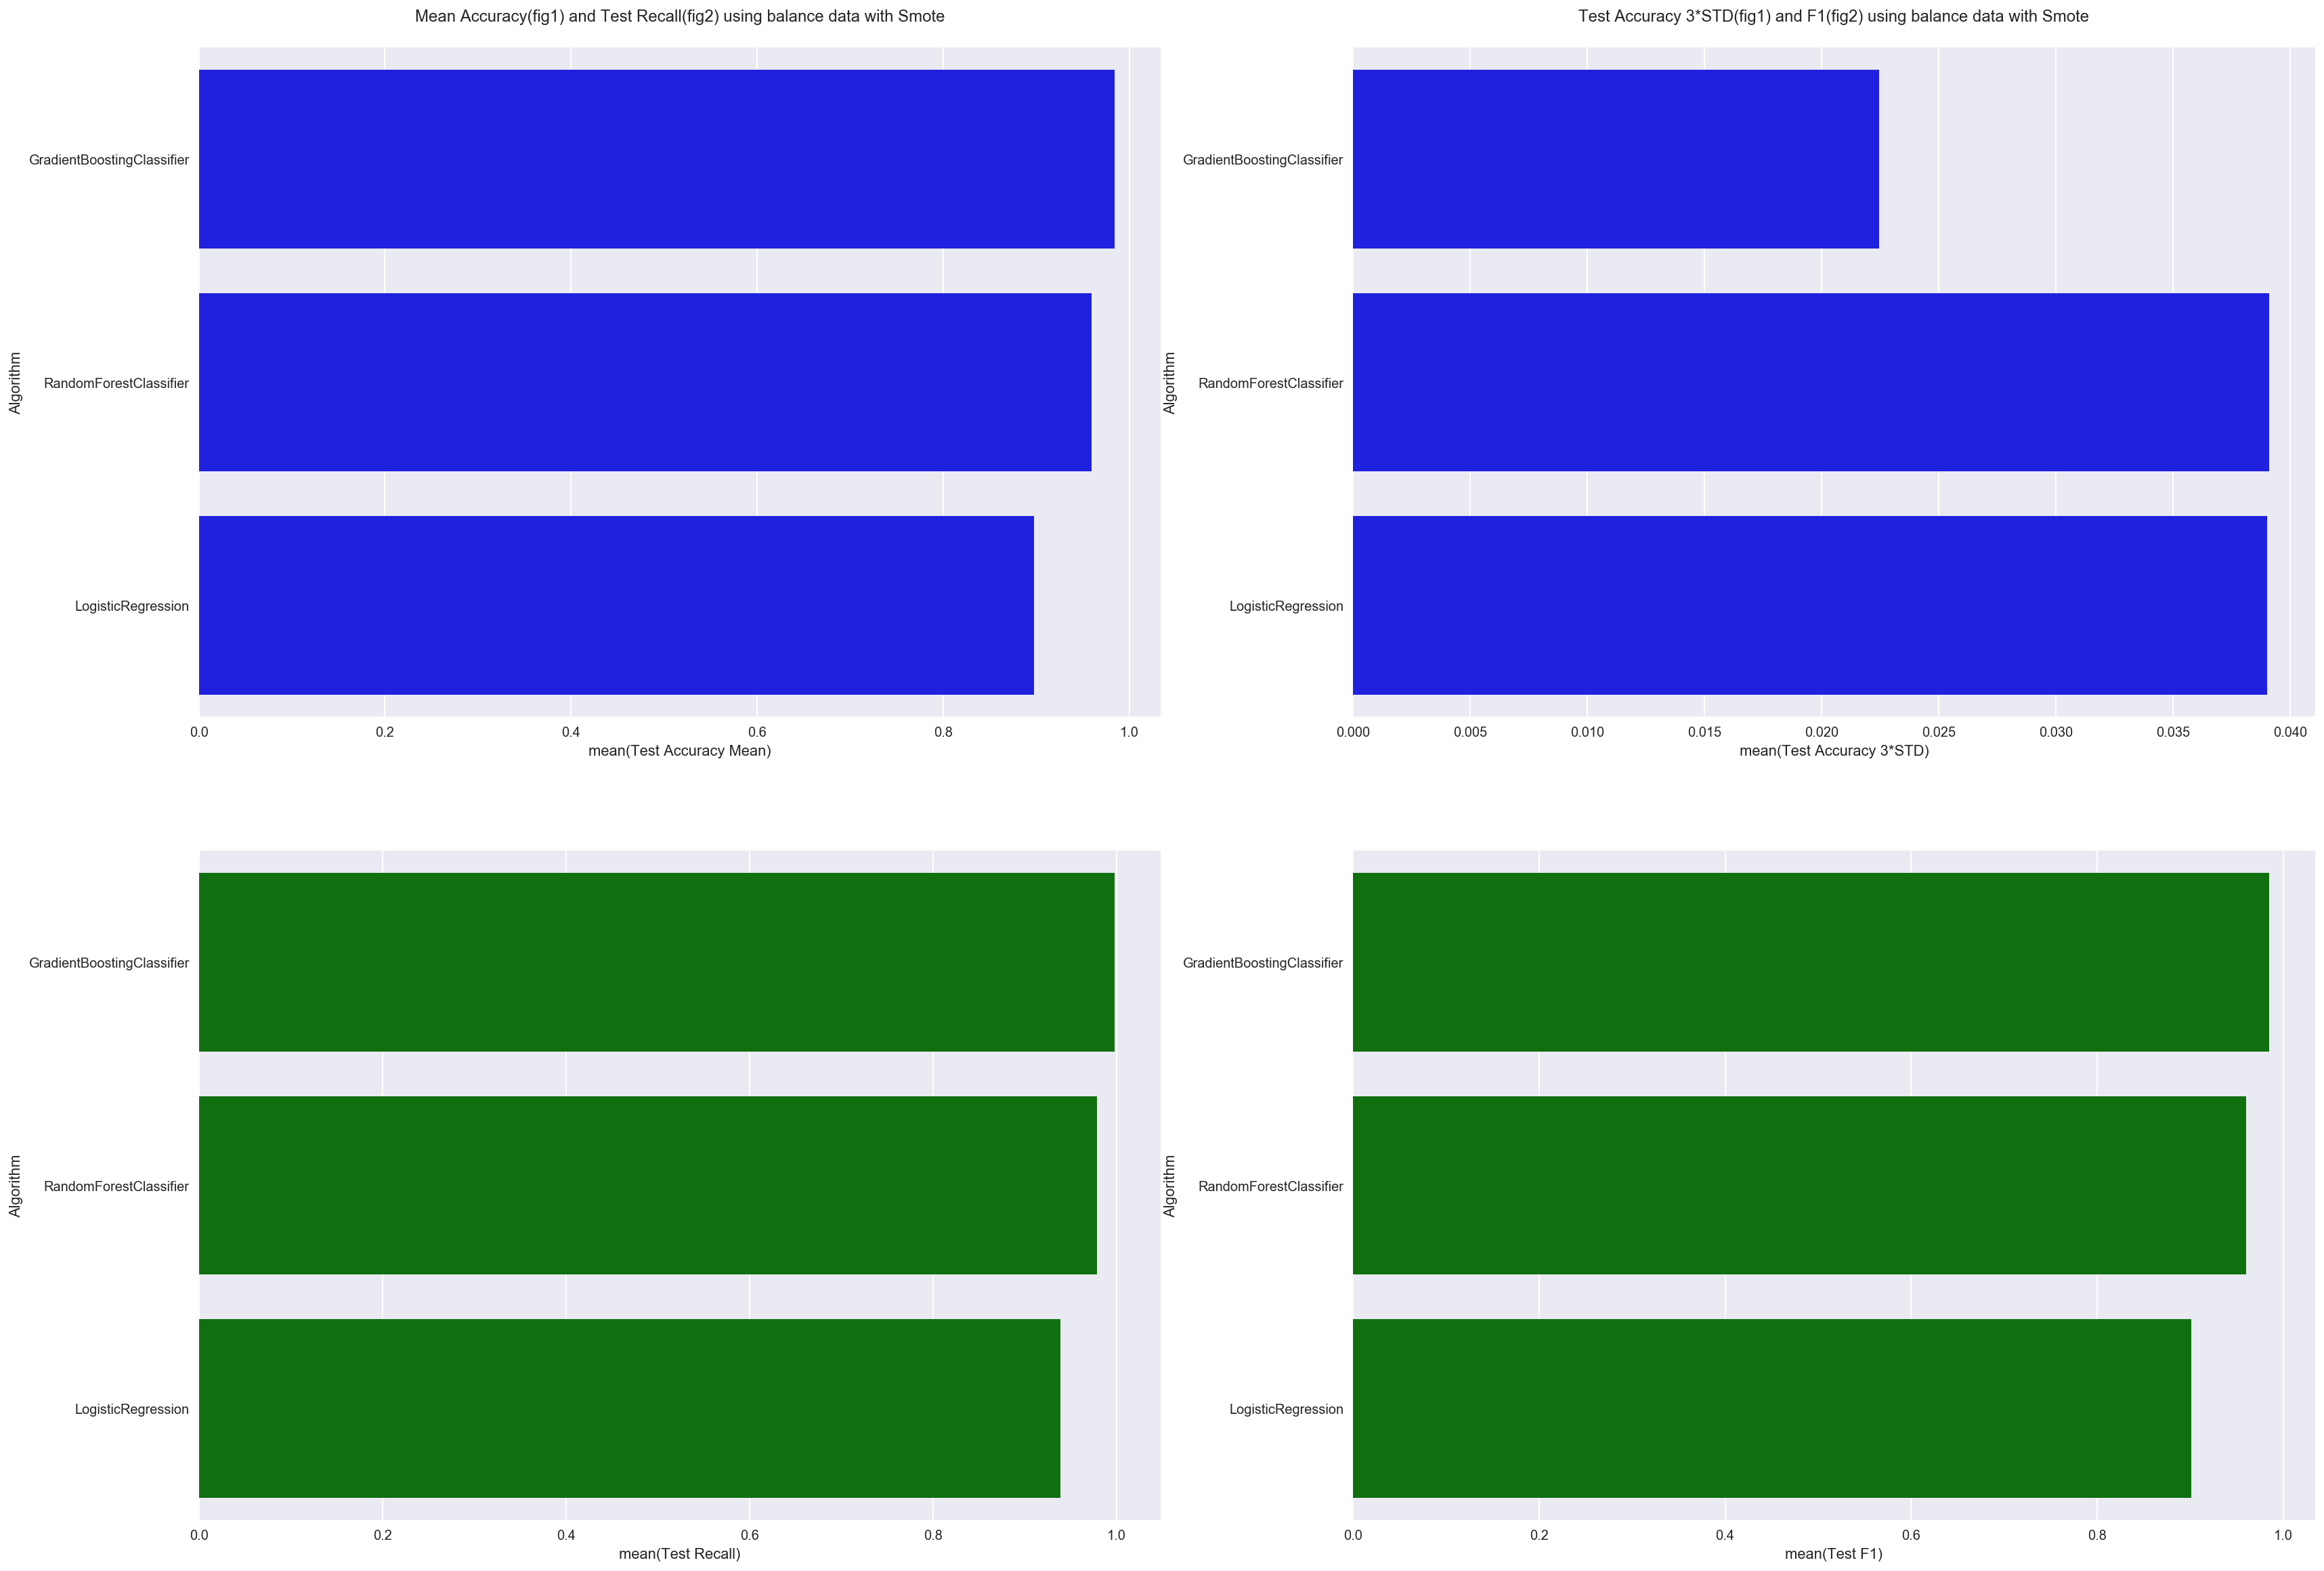

In [19]:
fig, axis = plt.subplots(2, 2,figsize=(28,20))
axis[0,0].set_title('Mean Accuracy(fig1) and Test Recall(fig2) using balance data with Smote\n')
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_res, color = 'b',ax = axis[0,0])
sns.barplot(x='Test Accuracy 3*STD', y = 'Algorithm', data = results_res, color = 'b',ax = axis[0,1])
axis[0,1].set_title('Test Accuracy 3*STD(fig1) and F1(fig2) using balance data with Smote\n')
sns.barplot(x='Test Recall', y = 'Algorithm', data = results_res, color = 'g',ax = axis[1,0])
sns.barplot(x='Test F1', y = 'Algorithm', data = results_res, color = 'g',ax = axis[1,1]);

### Test

* Utilizamos los datos de test sin balance de clases para testear nuestro modelo escogido (Gradient Boosting) y obtenemos los siguientes resultados:
  
    * Accuracy: 96%
    * Roc auc score: 0.97
    * Sensitivity: 62%
    * Specificity: 98%
    * Precisión de la clase positiva: 52%
    * Precisión de la clase negativa: 98%
    
    
* El modelo es muy bueno identificando a los tracks que no son reggaeton, pero tiene una performance menor para identificar a los que si lo son. Aún así, es el modelo con mayor precisión para la clase positiva y menor variabilidad.

In [20]:
def test_classifier(X_train, y_train, X_test, y_test, classifier,probs=False):
    classifier_name = str(type(classifier).__name__)
    print("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    print("Predicting values time {0}s".format(time() - now))
    if(probs):
        now = time()
        probs_prediction= model.predict_proba(X_test)
        print("Predicting probs time {0}s".format(time() - now))
        roc_auc   = roc_auc_score(y_test, probs_prediction[:,1])
    
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall    = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy  = accuracy_score(y_test, predictions)
    f1score   = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    cr        = classification_report(y_test, predictions)
    cm        = pd.crosstab(y_test, predictions, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
    results   = {classifier_name: 
                 {
                     'F1':f1score,
                     'Precision':precision,
                     'Recall':recall,
                     'Accuracy':accuracy,
                 }
                }
    if(probs):
        results.update({classifier_name: {
            'F1':f1score,
            'Precision':precision,
            'Recall':recall,
            'Accuracy':accuracy,
            'Roc-Auc':roc_auc} })
        return [results,cr,cm, predictions, probs_prediction]
    else:
        return [results,cr,cm,predictions]

In [21]:
algorithms=restart_classifiers(best_parameters_res)
classifier_LR=algorithms[0]
classifier_GB=algorithms[2]
selected_models=[classifier_LR,classifier_GB]
results=[]
classif_report=[]
confusion_matrix=[]
preds=[]
probs_prediction=[]
for model in selected_models:
    aux,cr,cm,predictions, probs=test_classifier(
        X_train=X_train_res, y_train=y_train_res,X_test=X_test, 
        y_test=y_test,classifier=model,probs=True)
    results.append(aux)
    classif_report.append(cr)
    confusion_matrix.append(cm)
    preds.append(predictions)
    probs_prediction.append(probs)

Testing LogisticRegression
Learing time 0.010023355484008789s
Predicting values time 0.0003440380096435547s
Predicting probs time 0.00035691261291503906s
Testing GradientBoostingClassifier
Learing time 0.7962586879730225s
Predicting values time 0.00462794303894043s
Predicting probs time 0.00439000129699707s


In [34]:
print("Accuracy del Gradient Boosting: {0}".format(results[1].get('GradientBoostingClassifier').get('Accuracy')))
print(classif_report[1])
confusion_matrix[1]

Accuracy del Gradient Boosting: 0.9636627906976745
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       657
          1       0.62      0.52      0.56        31

avg / total       0.96      0.96      0.96       688



Predicted class,0,1,All
Actual class,,,
0,647,10,657
1,15,16,31
All,662,26,688


In [23]:
print("Accuracy de la regresión logística: {0}".format(results[0].get('LogisticRegression').get('Accuracy')))
print(classif_report[0])
confusion_matrix[0]

Accuracy de la regresión logística: 0.8808139534883721
             precision    recall  f1-score   support

          0       0.99      0.88      0.93       657
          1       0.26      0.87      0.40        31

avg / total       0.96      0.88      0.91       688



Predicted class,0,1,All
Actual class,,,
0,579,78,657
1,4,27,31
All,583,105,688


0.9493297982029755


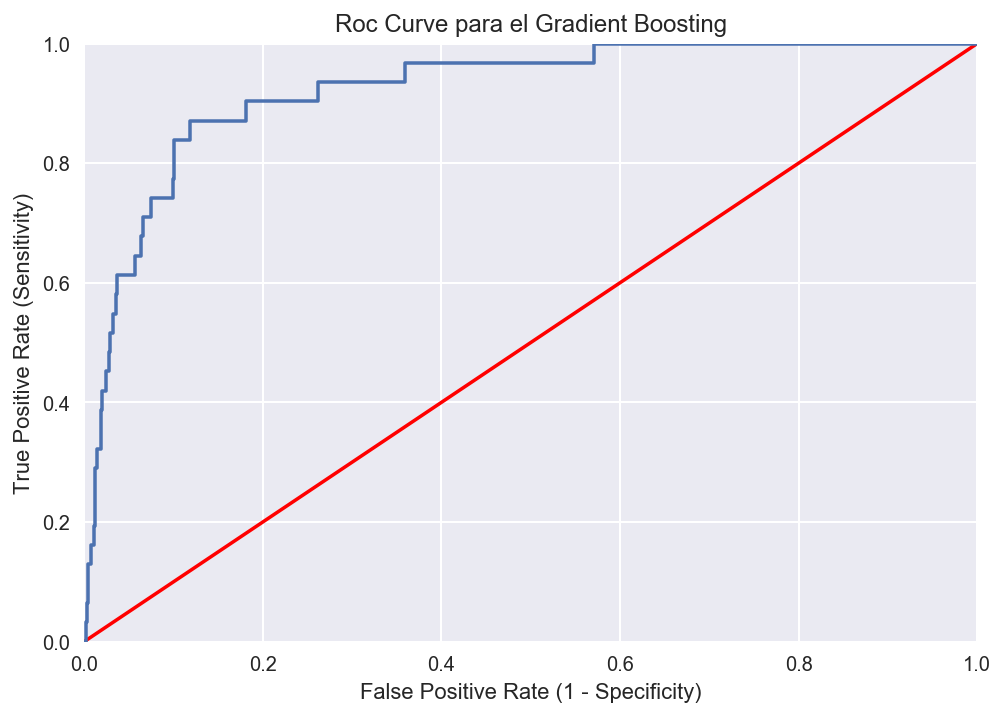

In [24]:
#Visualización de la curva ROC: equilibrio entre True (tpr) and False (fpr) Positive Rate
preds=binarize([probs_prediction[1][:,1]],0.5)[0]
print(results[1].get('GradientBoostingClassifier').get('Roc-Auc'))
line = np.linspace(0, 1, 2)
plt.plot(line, 'r')
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=probs_prediction[0][:,1],pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve para el Gradient Boosting')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True);

0.9234055089114745


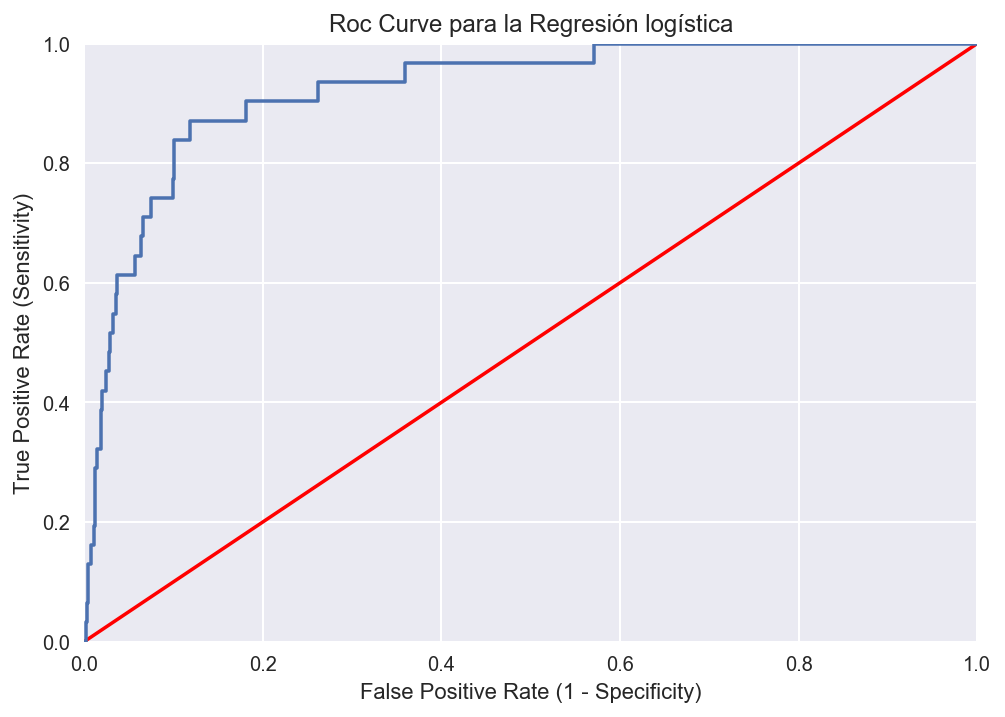

In [25]:
#Visualización de la curva ROC: equilibrio entre True (tpr) and False (fpr) Positive Rate
preds=binarize([probs_prediction[0][:,1]],0.5)[0]
print(results[0].get('LogisticRegression').get('Roc-Auc'))
line = np.linspace(0, 1, 2)
plt.plot(line, 'r')
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=probs_prediction[0][:,1],pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve para la Regresión logística')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True);

### Validaciones adicionales y análisis de resultados


** Validaciones adicionales: **

* Dado que la cantidad de datos de la clase positiva era muy baja como para dejar una muestra adicional para validar, hemos decidido hacer la siguiente validación:

    * Se grafica un histograma que muestra la distribución de probabilidad predicha para aquellas variables del data de test que si son reggaeton y las que no por separado. Lo esperable, es que mientras mejor sea el modelo, mayor cantidad de datos por arriba de una probabilidad de 0.5 debería haber en las que si y vicebersa en el contrario.

** Análisis de Resultados: **

* Como podemos ver, a pesar de que los modelos de GB y RF obtienen mejores precisiones de la clase positiva, es el modelo Regresión Logística el que obtiene una distribución de probabilidad más acorde a lo esperado al graficar los tracks de reggaeton. Sin embargo, vemos que el modelo de RF y GB lo hacen mejor cuando graficamos los que no son reggaeton.  
    
    
* En linea con lo anterior modelo de RL tienen el *recall* más alto en la clase positiva,sin embargo, tanto la *precisión* como el *F1*,*accuracy* y el *roc-auc* son más bajos que en el RF. Esto se debe a que este último identifica una menor cantidad de registros como reggaeton (24[3.4%]) con una mayor precisión (62%), mientras que la RL identifica 105(15%) con una precisión de apenas el 26%.


* Esto nos plantea una disyuntiva, pues dado que queremos un buen clasificador de reggaetones debemos ponderar dos objetivos:

    * Que identifique la mayor cantidad posible de los reggaetones en la muestra, y entonces deberíamos escoger el modelo de Regresión logística.
    
    * Determinar con la mayor precisión posible lo que es reggaeton y lo que no, entonces deberíamos escoger el modelo de Gradient Boosting
    
    
* En nuestro caso en particular, hemos optado por lo segundo, dado que queremos un clasificador que sea lo más preciso posible en sus predicciones

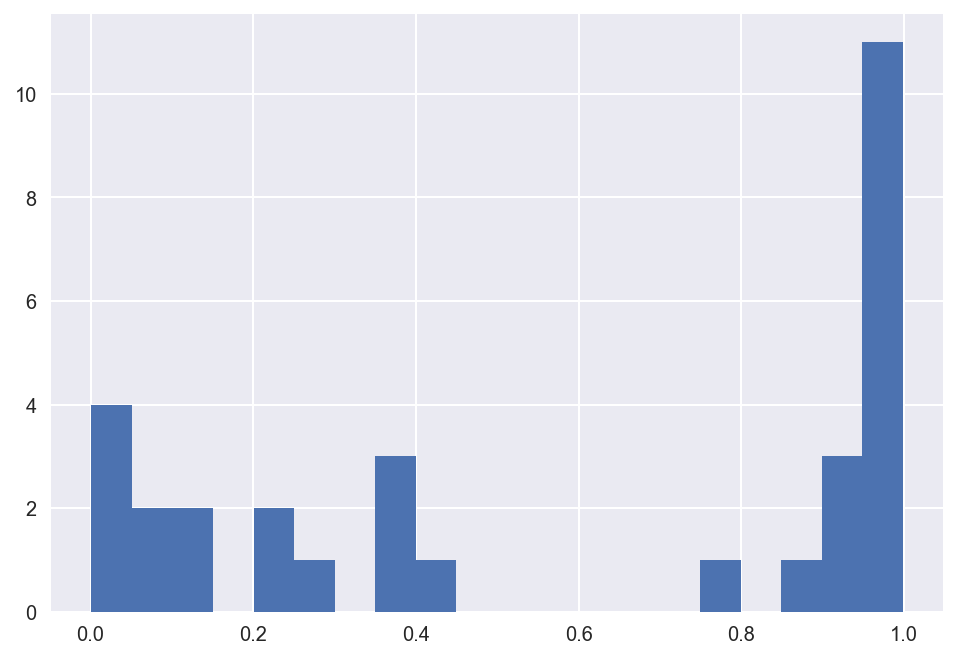

In [26]:
X_test['prob_reggaeton']=probs_prediction[1][:,1]
X_test['reggaeton']=y_test
X_test[(X_test.reggaeton==1)].loc[:,'prob_reggaeton'].hist(bins=20);

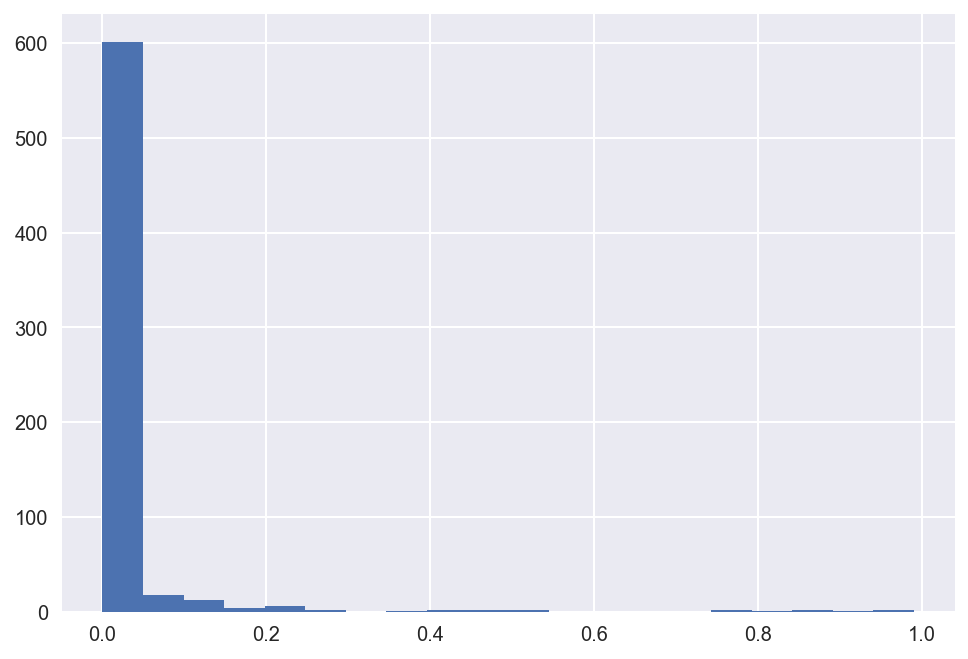

In [27]:
X_test[(X_test.reggaeton==0)].loc[:,'prob_reggaeton'].hist(bins=20);
del X_test['prob_reggaeton']
del X_test['reggaeton']

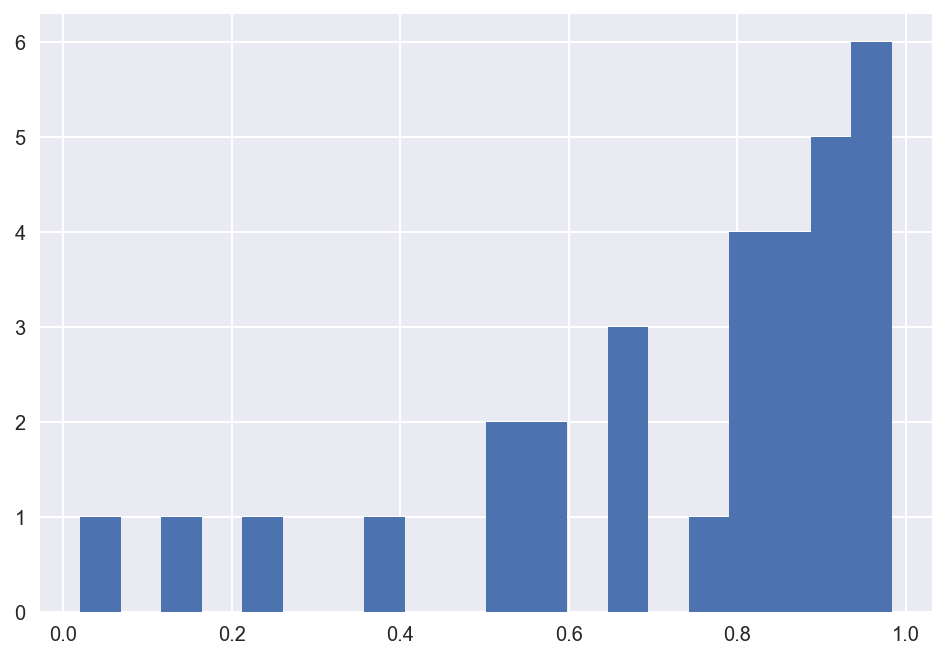

In [28]:
X_test['prob_reggaeton']=probs_prediction[0][:,1]
X_test['reggaeton']=y_test
X_test[(X_test.reggaeton==1)].loc[:,'prob_reggaeton'].hist(bins=20);

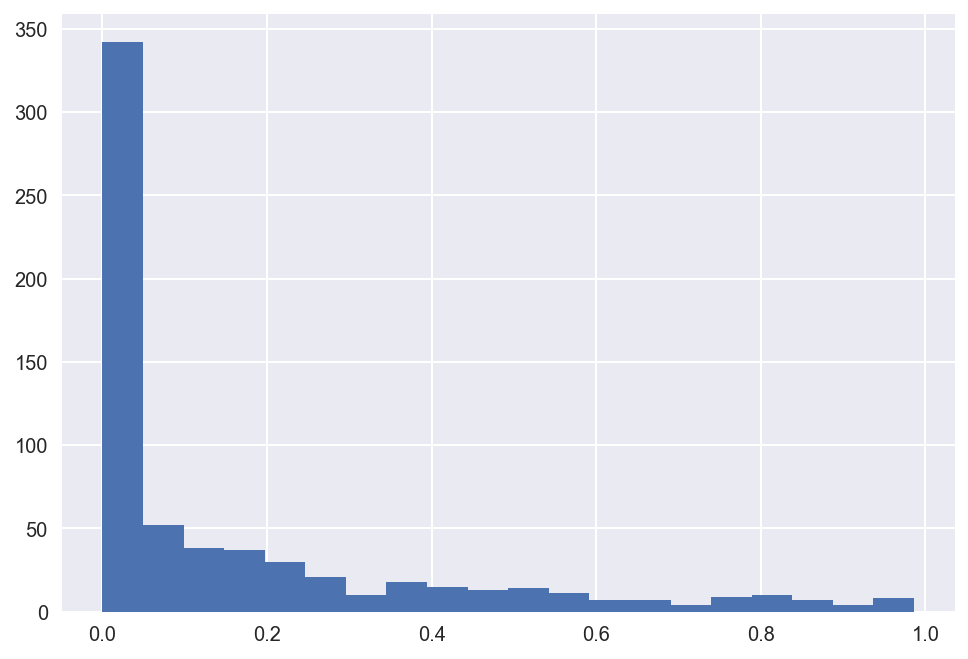

In [29]:
X_test[(X_test.reggaeton==0)].loc[:,'prob_reggaeton'].hist(bins=20);
del X_test['prob_reggaeton']
del X_test['reggaeton']

In [30]:
data={'names':X_train.columns.values,'coef':np.abs(classifier_GB.feature_importances_)}
aux=pd.DataFrame(data=data,columns=['names','coef'])
aux.sort_values(by='coef',ascending=False)

,names,coef
5,tempo_scale,0.218022
0,danceability,0.197936
3,acousticness,0.191175
1,energy,0.142353
4,valence,0.130894
2,speechiness,0.119620


In [31]:
data={'names':X_train.columns.values,'coef':np.abs(classifier_LR.coef_[0])}
aux=pd.DataFrame(data=data,columns=['names','coef'])
aux.sort_values(by='coef',ascending=False)

,names,coef
0,danceability,13.467178
2,speechiness,13.136569
5,tempo_scale,7.166609
1,energy,5.680083
3,acousticness,4.120669
4,valence,0.134828


### Optimizando a partir de las distribuciones de probabilidad predicha y según objetivos de negocio

* Al ser un algoritmo que entrega una probabilidad de ocurrencia, es posible adecuar el umbral de probabilidad utilizado según las prioridades y necesidades del problema. En este caso en particular vamos a hacer los siguientes supuestos: 
    
    * Dado que es un clasificador que recomienda música, si nos interesara más obtener una buena precisión cuando predecimos si una canción es o no es reggaeton por sobre el que identifique adecuadamente la mayor cantidad posible de reggaetones en la muestra (precisión de la clase positiva sobre sensitivity) porque queremos entregarle una recomendación adecuada a nuestro cliente cuando la hacemos, más que abarcar todas las posibles opciones.
      
    * También supondremos que estamos dispuesto a sacrificar *algo* (pero no mucho) de precisión en identificar los tracks que no son reggaeton


* Con esos supuestos, podemos mover el umbral hacia una probabilidad del 81% de ser reggaeton para que lo identifique como tal, y dado que estamos siendo más *exigentes* para identificarlo como tal el clasificador logra una mayor precisión de la clase positiva afectando levemente la precisión de la negativa pero fuertemente el sensitivity. Esto ocurre, dado que las clases negativas tienen una distribución de probabilidad muy cargada hacia la izquierda, es decir el clasificador es un buen predictor de las canciones que no son reggaeton y les atribuye una muy baja probabilidad de serlo, lo cual permite que el moviemiento del umbral no afecte signigicativamente las métricas de los tracks que nos son reggaetons pero disminuya el alcance para identificar los que si.

** Resultados  con el nuevo umbral: **

* Con este umbral, los resultados finales quedan de la siguiente forma:

    * Accuracy: 97% (sube un punto porcentual)
    * Roc auc score: 0.95 (queda igual)
    * Sensitivity: 48% (baja 4 puntos porcentuales)
    * Specificity: 99% (sube 1 punto porcentual)
    * Precisión de la clase positiva: 75% (sube 13 puntos porcentuales)
    * Precisión de la clase negativa: 98% 

** Los comentarios en paréntesis son la comparación con respecto a un umbral de probabilidad predicha de ser reggaeton de 0.5**

* Esto significa que si usamos este umbral, se espera que nuestro modelo obtenga un 97% de predicciones correctas,que el 75% de las canciones que clasifica como reggaeton se espera que lo sean y que logre predecir adecuadamente el 48% de las canciones de reggaeton del total que hay en Spotify y el 99% de las que no lo son con una precisión del 98%.

In [56]:
preds=binarize([probs_prediction[1][:,1]],0.81)[0]
print(accuracy_score(y_test, preds))
print(classification_report(y_test, preds))
pd.crosstab(y_test, preds, rownames=['Actual class'], colnames=['Predicted class'],margins=True)

0.9694767441860465
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       657
          1       0.75      0.48      0.59        31

avg / total       0.97      0.97      0.97       688



Predicted class,0.0,1.0,All
Actual class,,,
0,652,5,657
1,16,15,31
All,668,20,688


0.9493297982029755


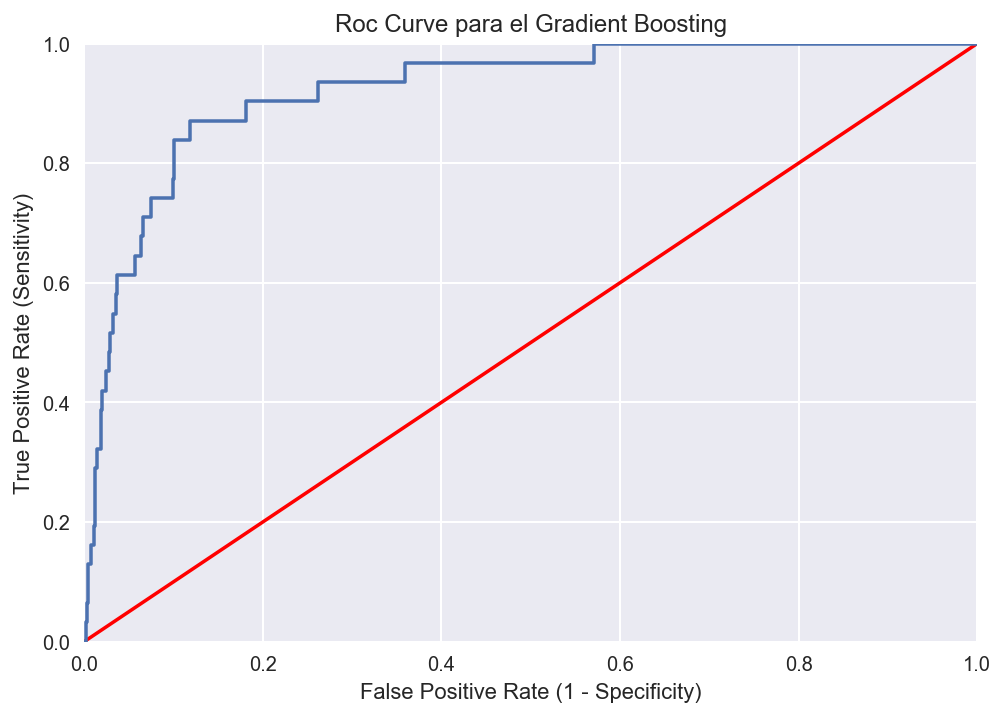

In [33]:
print(results[1].get('GradientBoostingClassifier').get('Roc-Auc'))
line = np.linspace(0, 1, 2)
plt.plot(line, 'r')
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=probs_prediction[0][:,1],pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve para el Gradient Boosting')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True);